In [1]:
from pathlib import Path
import shutil

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from bs4 import BeautifulSoup
import locale
#from html.parser import HTMLParser
# import website_func.py to use its functions
from website_func import *
from scrap import *
import os #To read the file
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get

#Machine learning part
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_confusion_matrix

#reload every module each time
%load_ext autoreload
%autoreload 2

C:\Users\Elias\Desktop\master_1\applied data analysis\projet\ADA_pADAwan_Project\scrap.py:56: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  augmented_quantity_dict = pd.read_pickle('data_pickles/augmented_quantity.pkl').set_index("Food").T.to_dict("list")


ModuleNotFoundError: No module named 'mlxtend'

# Some quick analysis of the data
We received a data set of .html file containing the website content of recipes.
We wanted to sort them by website, in order to, more easily, find a pattern among them. This will enable us to do the "scraping" of the pages. First we thought about moving the files in a folder corresponding to their website, but it would be a waste of time and a big computational effort. Thus, we came up with a (probably) faster solution : we could simply write the name of the file within its corresponding website folder. By inspecting the files, we saw that the first line was always containing a comment with the name of the file and the complete website. Using readlines and split, we could easily retrieve the name of the website.

We launched this process, but an alarm appeared describing a Trojan virus in the file "1c2cb6f0df04cf5a9d0baa116c6aa7bb.html". 
We had then to quarantine or maybe remove the file, as we have quite enough data.
By doing so, we remarked the file "msg.log" that could help us into fastering the processus as its content is formed of the name of the file together with its website.

In [110]:
with open("recipePages/msg.log", 'r') as f:
    first_lines = f.readlines()[45:49]
    print(*first_lines, sep="--")

59b9d3c43ee8df52fcd04128475059f5.html	http://allrecipes.com/Recipe/bacon-and-potato-soup/detail.aspx	2012-09-09 10:55:41 URL:http://allrecipes.com/Recipe/bacon-and-potato-soup/detail.aspx [225697/225697] -> "59b9d3c43ee8df52fcd04128475059f5.tmp" [1]
--129b4dad66e6d0d59bbc6f3200f9e927.html	http://familyoven.com/recipes/search?terms=Dairy%20Free%20Alfredo%20Sauce	2012-09-09 10:55:42 URL:http://familyoven.com/recipes/search?terms=Dairy%20Free%20Alfredo%20Sauce [77640] -> "129b4dad66e6d0d59bbc6f3200f9e927.tmp" [1]
--bafcd30bc137238af0cd9954f7d0701e.html	http://www.yummly.com/recipes/chicken-brunswick-stew-lima-beans	Syntax error in Set-Cookie: fbsr_54208124338=""; Expires=Thu, 01-Jan-1970 00:00:10 GMT; Path=/, JSESSIONID=27D73083292D7FE540727DC4AD6C50D2; Path=/; HttpOnly, yv="lJSpLE5cHmHHgrNrJgtM/w=="; Version=1; Max-Age=31536000; Expires=Mon, 09-Sep-2013 17:55:42 GMT; Path=/ at position 120.
--2012-09-09 10:55:43 URL:http://www.yummly.com/recipes/chicken-brunswick-stew-lima-beans [286650]

We observed that occasionally a line containing other info that are not necessary can appear (in the example above, this is the case in the last line). Those lines are ignored during the sorting process.
Also we noticed there are no file extensions other than .html and .log (see below). Thus, we know exacty what the contents of the folder recipePages are.

In [111]:
# We can find in the folder that, excepted the html files, there is only the log
# Get all filenames (i.e. path) that are in recipePages folder 
pathlist = Path("recipePages/").glob('**/*')
i = 0
for path in pathlist:
     # because path is object not string
    path_in_str = str(path)
    if not path_in_str.endswith(".html"):
        print(path_in_str)

recipePages\msg.log


##### Sorting part of the content of the folder "recipePages" :

In [112]:
# If override True -> delete SortedFiles and re-execute the function (long)
sort_website_from_log(override=False)

Finished sorting the files


After the sorting comes the scraping part. In order to have the maximum number of data and to save some time, we'll first scrap the websites containing the higher number of files.

In [113]:
website_count=pd.Series()

for (root,dirs,files) in os.walk('SortedFiles', topdown="True"):   
        for website in dirs:
            if website == ".ipynb_checkpoints":
                continue
            filename = "SortedFiles/" + website +"/filesName.txt"
            
            f = open(filename, "r")
            number_of_link = len(f.readlines())
            line_to_add=pd.Series(number_of_link,index=[website])
            website_count = website_count.append(line_to_add)

In [114]:
#print(website_count)
print("Number of website with more than 1000 files:", len(website_count[website_count.values >1000]))
print("Number of website with less than 1000 files:", len(website_count[website_count.values <1000]))

Number of website with more than 1000 files: 19
Number of website with less than 1000 files: 85


As we can observe, 19 websites have a really high number of files, higher than a thousand. The number of files contained in the 3 first website represents 53% of the total number of files.Those are the ones that we'll focus our attention on.

In [115]:
website_count.sort_values(ascending=False,inplace=True)
website_count_used=website_count[website_count.values>1000]
print(website_count_used)
total_number_files = website_count_used.values.sum()
chosen_number_files = website_count_used[0:3].values.sum()

print("Number of files in the 3 first domains : ", chosen_number_files)
print("Percentage of chosen files among the total: ", chosen_number_files/total_number_files)

allrecipes.com             28355
food.com                   14661
foodnetwork.com            11997
yummly.com                  6590
cooks.com                   5547
epicurious.com              5060
tasteofhome.com             4820
myrecipes.com               3805
recipes.sparkpeople.com     3671
cdkitchen.com               2584
bettycrocker.com            2325
cookeatshare.com            2044
southernfood.about.com      2012
grouprecipes.com            1916
recipe.com                  1460
kraftrecipes.com            1420
eatingwell.com              1400
ifood.tv                    1295
delish.com                  1050
dtype: int64
Number of files in the 3 first domains :  55013
Percentage of chosen files among the total:  0.539279692585186


In [116]:
website_list_used=website_count_used.index.tolist()

There is a lot of words in the ingredients which aren't specific to the ingredient itself, but which are just linked to the quantity of the ingredients, or something uninteresting for us. It is difficult to extract the quantity of the ingredients, as there is a lot of different units for expressing them. Hence, we decided first to juste remove all those terms for the moment, and focus our attention only on the ingredients (not on the quantity). 

In [117]:
#Words that have to be removed from the string in the website to keep only the ingredient:
list_ingredient_to_remove = ["that", "store","tsp","such", "shape","softened","warm","how","generous","equivalent","bottom","needed","salted","replace",\
                             "low","i","believe","ever", "only", "fine", "envelopes", "your","own","inches","run","through","perfect", "into","big","oz",\
                             "substitute","am","using","will", "enhance","the","not","may","be","correct","desired","you","like","less","in water",\
                             "delicious","big","save","time","use the cheap cooking wine","gram","used","be", "little","more","gallon","gal","pound","pounds","if","let","sit","kg","works","really","is",\
                             "approximate","ml", "sprinkle","over","amount","dl","use", "a", "preserved","g","gr","real","raw","lb", "lbs","metrics",\
                             "metric","of","teaspoon", "cup", "cups","teaspoons","ounce","ounces","pounds","pound","tablespoons","chopped","quarts","fresh",\
                            "light","plain","popped","medium","shredded","bunch","tablespoon","to","taste","pinch","freshly","ground",\
                            "canned","carcass","cubes","dried","frozen","all","purpose","grated","minced","degree","degrees","optional",\
                            "jar","quartered","marinated","strips","strip","asian","stalks","package","can","cans","box","container",\
                            "evaporated","bottle","cans","extract","squares","german","slices","crushed","uncooked","seasoning","small",\
                            "sweet","packed","sliced","heavy","condensed","finely","long","grain","sweetened","firmly","cooked","crusts","lean",\
                            "caps","mix","steaks","large","instant","crumbs","semisweet","distilled","packages","pint","miniature","preserves",\
                            "processed","chunky","prepared","seasoned","american","stock","top","sirloin","tip","peeled","spears","leaves",\
                            "belgian","bob","italian","bottles","boneless","roast","breast","meat","tenderloins","granules","chips","converted",\
                            "containers","coleslaw","florets","cube","cubed","diced","crumbled","head","thighs","halves","drumsticks","blend",\
                            "leaf","bow","tie","stuffing","dry","boiling","cover","coarse","kosher","extra","virgin","fat","free","fluid","hot",\
                            "chops","loin","shoulder","roasted","for","frying","diced","thawed","bone","hocks","shucked","leftover","corned",\
                            "weed","summer","wild","whole","very","ripe","unbaked","crust","unsalted","unsifted","unsweetened","drops","drop",\
                            "paste","thickly","swiss","skinless","flavored","quart","puff","kernels","kernel","cracked","as","tortillas","chunk",\
                            "dash","dark","hash","hashbrown","hungarian","rinsed","thin","thinly","thick","stewed","cleaned","gelatin",\
                            "sifted","skim","slivered","sprigs","sage","roma","romano","reduced","sodium","refried","refrigerated",\
                            "portobello","nuggets","tater","pinto","pudding","pitted","pinches","relish","penne","deep","mild","melted",\
                            "maraschino","loaf","link","jumbo","inch","jars","jasmine","generous","gold","graham","granulated","fried","skins",\
                            "fire","firm","flaked","flank","family","size","eagle","curd","half","russet","round","vidalia","unbleached","toll",\
                            "morsels","toasted","square","soft","sharp","serrano","seedless","old","provolone","process","premium","pouch","betty",\
                            "piri","chunks","smoked","other","original","breaded","tender","tenders","flowerets","nonfat","no","calorie","tail",\
                            "greek","great","northern","southern","envelope","dill","cold","round","steak","brisket","baby","assorted", "cloves",\
                            "clove", "flakes", "active", "balsamic", "whipping", "breasts", "sea", "zest", "powdered", "pure", "topping", "whipped",\
                            "monterey", "jack", "stalk", "kidney", "stick", "garbanzo", "elbow", "fillet", "plum", "good","quick", "people", "being",\
                            "glazed", "blanched", "add","minutes","lightly", "prefer", "this", "double", "enough","(approximate", "(again", "center",\
                            "amount.)", "brown"]

list_ingredient_to_remove = sorted(list_ingredient_to_remove)
#print(list_ingredient_to_remove)

We can also add a list of ingredient (here fruit) that contains the average serving portion for each fruit. We scraped the website https://www.calories.info to get those measures.

In [69]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
# quantity in grams
augmented_quantity = pd.DataFrame(columns=["Food", "Serving", "Unit"])

website_fruit = "https://www.calories.info/food/fruits"
req = requests.get(website_fruit)
soup = BeautifulSoup(req.text, 'html.parser')
for link in soup.find(id="menu-calorie-tables").findAll('a'):
    req = requests.get(link.get("href"))
    soup1 = BeautifulSoup(req.text, 'html.parser')
    rows =  soup1.find('tbody').findAll('tr')
    for r in rows:
        name = r.find("a").text
        complete_weight =r.find("td", class_="serving portion").text.split("(")[1].replace(")","").split()
        weight = float(complete_weight[0])
        augmented_quantity =augmented_quantity.append({'Food':name.lower(), 'Serving' : weight, 'Unit': complete_weight[1]}, ignore_index = True)
augmented_quantity.to_pickle("data_pickles/augmented_quantit.pkl")

### Creation of the recipe data:
We have to be aware of certain things:
- we might get a website containing only a list of recipes
- we might find no rating -> we'll have to discard it
- we might not be able to open and read the file

For the pages containing lists of recipes, we tried to get informations about those recipes, but were unsucessful. As some links referenced in those were dead.

### Schema used for the scraping :

We will based our dataset on the 3 first websites as said before. The variables we are interested in are the following :
- The ranking, in order to have a value representing the success of the recipe.
- The number of reviews, in order to have an idea of the confidence interval for the ranking estimation.
- The time of preparation, which is a candidate which will be used to predict the ranking.
- The ingredients : The candidate which will be used to predict the ranking.

We haven't yet decided what to do exactly with the number of reviews, but as we want our ranking estimation to be significant enough, we could simply remove the recipes with a too small number of reviews.

## Pickle part of food.com

The scraping takes a lot of time, then, after each website scraped, we store the results in pickles files.

In [118]:
# Scrap all food.com files and put them in a pickle file
recipe_data_food = pd.DataFrame(columns = ['Website','Recipe','Prepare time', 'Ranking', 'Reviews', 'Ingredients'])  
list_unique_ingredients_food = []
unique_ingredients_data_food = pd.DataFrame(columns = ['Ingredient','Count'])
path_to_food_folder = Path('SortedFiles/food.com/filesName.txt')
print(path_to_food_folder)
i = 0
with path_to_food_folder.open("r") as file:
    website = "food.com"
    for f in file.readlines():
        file_to_read =Path('recipePages') / f.strip()
        try:
            f = open(file_to_read,'r')
            f.close()
        except:
            #print("We can't read the page: ",file_to_read)
            continue
        i+=1 
        if i % 250 == 0:
            print(i)
        recipe_data_food, list_unique_ingredients_food, unique_ingredients_data_food = scrap_food(website, file_to_read,list_ingredient_to_remove,list_unique_ingredients_food, recipe_data_food, website_list_used,unique_ingredients_data_food)

SortedFiles\food.com\filesName.txt
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
14250
14500


In [120]:
recipe_data_food.head()

,Website,Recipe,Prepare time,Ranking,Reviews,Ingredients,Quantities,Units
0,food.com,Ecuadorean Quinoa and Vegetable Soup,75,4.86,31,"[quinoa, olive oil, onions, salt, potato, red ...","[0.5, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[cup, tablespoons, cups, teaspoon, cup, cup, c..."
1,food.com,Authentic Injera (aka Ethiopian Flat Bread),4330,3.13,17,"[teff, water]","[1.500, 2.0]","[cups, cups]"
2,food.com,Healthy Vegan Coleslaw,10,5.00,1,"[cabbage, vegan mayonnaise, apple cider vinega...","[908.0, 0.5, 1.0, 1.0, 1.0, 0.125, 1.0]","[g, cup, tablespoon, tablespoon, tablespoon, t..."
3,food.com,Grilled Flatbread,35,4.67,14,"[yeast, olive oil, flour, salt]","[0.5, 1.0, 1.333, 1.0]","[teaspoon, tablespoon, cups, teaspoon]"
4,food.com,Baked Margarita Pie,20,5.00,3,"[cracker, pie pastry, bottled margarita, egg y...","[7.0, 7.0, 0.75, 2.0, 244.0]","[g, g, cup, -1.0, ml]"


In [135]:
# Check for difference in the length of lists
for i in range(len(recipe_data_food)):
    if len(recipe_data_food.iloc[i]["Ingredients"]) != len(recipe_data_food.iloc[i]["Units"]) or \
    len(recipe_data_food.iloc[i]["Ingredients"]) != len(recipe_data_food.iloc[i]["Quantities"]) or \
    len(recipe_data_food.iloc[i]["Quantities"]) != len(recipe_data_food.iloc[i]["Units"])    :
        print(recipe_data_food.iloc[i]["Ingredients"], recipe_data_food.iloc[i]["Units"], recipe_data_food.iloc[i]["Quantities"])

##### Save data with pickle:

In [123]:
recipe_data_food.to_pickle("data_pickles/recipe_data_food.pkl")
unique_ingredients_data_food.to_pickle("data_pickles/unique_ingredients_data_food.pkl")
with open('data_pickles/list_uni_ingr_food.pkl', 'wb') as f:
    pickle.dump(list_unique_ingredients_food, f)

##### Retrieve data with pickle:

In [124]:
recipe_data = pd.read_pickle("data_pickles/recipe_data_food.pkl")
unique_ingredients_data = pd.read_pickle("data_pickles/unique_ingredients_data_food.pkl")
with open('data_pickles/list_uni_ingr_food.pkl', 'rb') as f:
    list_unique_ingredients = pickle.load(f)

In [134]:
unique_ingredients_data[0:50].Ingredient.values

array(['quinoa', 'olive oil', 'onions', 'salt', 'potato',
       'red bell peppers', 'green bell pepper', 'coriander', 'cumin',
       'oregano', 'pepper', 'water vegetable', 'vegetable', 'tomatoes',
       'zucchini', 'yellow squash', 'lemon juice', 'teff', 'water',
       'cabbage', 'vegan mayonnaise', 'apple cider vinegar', 'mustard',
       'splenda granular', 'yeast', 'flour', 'cracker', 'pie pastry',
       'bottled margarita', 'egg yolks', 'milk', 'oil', 'sesame tahini',
       'soy sauce', 'garlic', 'baking soda', 'white vinegar',
       'orange essential oils', 'lemon essential oils', 'essential oils',
       'gingerbread cake', 'cranberries', 'eggs', 'cream', 'sugar',
       'cinnamon', 'ginger', 'vanilla', 'oatmeal', 'onion'], dtype=object)

In [125]:
# Scrap all foodnetwork.com files and put them in a pickle file
path_to_foodnet_folder = Path('SortedFiles/foodnetwork.com/filesName.txt')
print(path_to_foodnet_folder)

with path_to_foodnet_folder.open("r") as file:
    website = "foodnetwork.com"
    for f in file.readlines():
        file_to_read =Path('recipePages') / f.strip()
        try:
            f = open(file_to_read,'r')
            f.close()
        except:
            #print("We can't read the page: ",file_to_read)
            continue
        recipe_data,list_unique_ingredients, unique_ingredients_data= scrap_foodnetwork(website, file_to_read,list_ingredient_to_remove,list_unique_ingredients, recipe_data, website_list_used,unique_ingredients_data)


SortedFiles\foodnetwork.com\filesName.txt
1 /2
1 /2
1 /4
lemon/lime
lemon/lime
1 /2
1 /2
3 /4


In [126]:
recipe_data.to_pickle("data_pickles/recipe_data_foodnet.pkl")
unique_ingredients_data.to_pickle("data_pickles/unique_ingredients_data_foodnet.pkl")
with open('data_pickles/list_uni_ingr_foodnet.pkl', 'wb') as f:
    pickle.dump(list_unique_ingredients_food, f)

In [127]:
recipe_data = pd.read_pickle("data_pickles/recipe_data_foodnet.pkl")
unique_ingredients_data = pd.read_pickle("data_pickles/unique_ingredients_data_foodnet.pkl")
with open('data_pickles/list_uni_ingr_foodnet.pkl', 'rb') as f:
    list_unique_ingredients = pickle.load(f)

In [128]:
# Scrap allrecipes.com files and put them in a pickle file
path_to_allrec_folder = Path('SortedFiles/allrecipes.com/filesName.txt')
print(path_to_allrec_folder)

with path_to_allrec_folder.open("r") as file:
    website = "allrecipes.com"
    for f in file.readlines():
        file_to_read =Path('recipePages') / f.strip()
        try:
            f = open(file_to_read,'r')
            f.close()
        except:
            #print("We can't read the page: ",file_to_read)
            continue
        recipe_data, list_unique_ingredients, unique_ingredients_data = scrap_allrecipes(website, file_to_read,list_ingredient_to_remove,list_unique_ingredients, recipe_data, website_list_used,unique_ingredients_data)


SortedFiles\allrecipes.com\filesName.txt
text time ['1', '']  filename recipePages\de99525a292043563494ac719d46de87.html
text time ['11', '']  filename recipePages\9c46dfef68d46030f60d925c060fa766.html
text time ['1', '']  filename recipePages\33f24fcdfb869f9326670dad8f7deb1a.html
text time ['11', '']  filename recipePages\3e3a93f4c1367c0b6d1073975aeb5e5a.html
text time ['1', '']  filename recipePages\04994c7850906c089603fe1e82ca94ad.html
text time ['21', '']  filename recipePages\4c055b79be557337be869bd6392f18f4.html
text time ['1', '']  filename recipePages\706f2de333621274d4f27ea3f500caeb.html
text time ['1', '']  filename recipePages\9d93bb9e2aeef7b06a8a71884b1be03c.html
text time ['21', '']  filename recipePages\1a4d6ef14b59909d0b21af65b964dfd1.html
text time ['11', '']  filename recipePages\b960bb8732fea68e1883b736d35caaa3.html
text time ['7', '']  filename recipePages\b433e4044ffc8cdb713f95f3214775cc.html
text time ['7', '']  filename recipePages\db89d4c24be55c157601f4397fbc908d

In [129]:
recipe_data.to_pickle("data_pickles/recipe_data_complete.pkl")
unique_ingredients_data.to_pickle("data_pickles/unique_ingredients_data_complete.pkl")
with open('data_pickles/list_uni_ingr_complete.pkl', 'wb') as f:
    pickle.dump(list_unique_ingredients_food, f)

In [18]:
recipe_data = pd.read_pickle("data_pickles/recipe_data_complete.pkl")
unique_ingredients_data = pd.read_pickle("data_pickles/unique_ingredients_data_complete.pkl")
with open('data_pickles/list_uni_ingr_complete.pkl', 'rb') as f:
    list_unique_ingredients = pickle.load(f)

In [27]:
recipe_data.head(15)

,Website,Recipe,Prepare time,Ranking,Reviews,Ingredients,Quantities,Units
0,food.com,Ecuadorean Quinoa and Vegetable Soup,75,4.86,31,"[quinoa, olive oil, onions, salt, potato, red ...","[0.5, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[cup, tablespoons, cups, teaspoon, cup, cup, c..."
1,food.com,Authentic Injera (aka Ethiopian Flat Bread),4330,3.13,17,"[teff, water]","[1.500, 2.0]","[cups, cups]"
2,food.com,Healthy Vegan Coleslaw,10,5,1,"[cabbage, vegan mayonnaise, apple cider vinega...","[908.0, 0.5, 1.0, 1.0, 1.0, 0.125, 1.0]","[g, cup, tablespoon, tablespoon, tablespoon, t..."
3,food.com,Grilled Flatbread,35,4.67,14,"[yeast, olive oil, flour, salt]","[0.5, 1.0, 1.333, 1.0]","[teaspoon, tablespoon, cups, teaspoon]"
4,food.com,Baked Margarita Pie,20,5,3,"[cracker, pie pastry, bottled margarita, egg y...","[7.0, 7.0, 0.75, 2.0, 244.0]","[g, g, cup, -1.0, ml]"
5,food.com,Lemon Tahini Dressing,5,4.25,4,"[lemon juice, oil, sesame tahini, soy sauce, w...","[0.25, 3.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0]","[cup, tablespoons, tablespoons, tablespoon, ta..."
6,food.com,Homemade Fabric Softener,5,4.91,25,"[baking soda, white vinegar, water, orange ess...","[1.0, 6.0, 8.0, 10.0, 10.0, 10.0]","[cup, cups, cups, -1.0, -1.0, -1.0]"
7,food.com,Gingerbread Bread Pudding,50,5,2,"[gingerbread cake, cranberries, eggs, milk, cr...","[1.0, 0.75, 4.0, 1.500, 0.5, 0.5, 1.0, 0.5, 1....","[lb, cup, -1.0, cups, cup, cup, teaspoon, teas..."
8,food.com,Reindeer Food,5,5,14,"[oatmeal, sugar]","[0.25, 0.25]","[cup, cup]"
9,food.com,Turkey Spaghetti Casserole,85,4.75,14,"[onion, carrot, celery rib, mushrooms, butter,...","[85.0, 61.0, 1.0, 0.3333333333333333, 1.0, 2.5...","[g, g, -1.0, cup, tablespoon, cups, -1.0, teas..."


In [28]:
recipe_data.groupby(['Recipe','Website','Reviews','Ranking','Prepare time']).count().sort_values(by=['Ingredients'])

,,,,,Ingredients,Quantities,Units
Recipe,Website,Reviews,Ranking,Prepare time,,,
""" Ant"" Kelly's London Broil Marinade",food.com,73,4.76,200,1,1,1
Mock Chicken Legs,allrecipes.com,2,4.5,105,1,1,1
Mock Caviar,allrecipes.com,14,4.7,485,1,1,1
Mock Beef Tenderloin,food.com,7,5.0,65,1,1,1
Mochi,food.com,15,4.57,33,1,1,1
...,...,...,...,...,...,...,...
Grilled Corn on the Cob,allrecipes.com,312,4.4,40,9,9,9
Slow Cooker Corned Beef and Cabbage,allrecipes.com,378,4.6,555,10,10,10
Texas Sheet Cake V,allrecipes.com,343,4.7,30,11,11,11


To Do: Reset index for unique_ingredients_data

We choose to take only the ingredients which have an higher value than 200.

### Preprocessing:
As a first step, we need to select the features on which we will train our model. This selection will help us to focus on the most important variables and hence to reduce the dimensionality. Furthermore, making a selection will simplify the model and avoid overfitting. We will test a couple of methods for feature extraction, but first of all, a good approach is to analyze the correlations between our variables.

Before, to do that, we have to work on 2 points :
- A) One of our task is to analyze the success of ingredients in recipes. To ensure a certain confidence in our statistics, the ingredient analyzed should appear in a lot of recipes. Then, we have to suppress all the rare ingredients (the ingredients which appear only a small number of times in our dataset).
- B) We want to have an idea of how important is each ingredient in recipes. Then we choose to give weights to each ingredient within each recipes. By the following, we would set the weigth as $\frac{ingredient\_mass}{sum\_of\_ingredient\_mass}$.

A) let's ignore the ingredients which appear less than minAppearingThresh

,Ingredient,Count
3,salt,22559
53,butter,12649
92,egg,10573
44,sugar,10396
25,flour,10290
...,...,...
3064,caper,209
251,cayenne,209
5376,black peppercorn,208
464,tofu,204


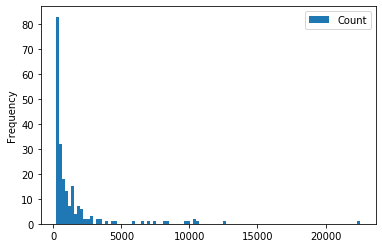

In [29]:
minAppearingThresh = 200
unique_ingredients_data.sort_values(by=["Count"], ascending=False,inplace=True)
unique_ingredients_data[unique_ingredients_data['Count'].values>minAppearingThresh].plot.hist(x="Ingredient", y="Count", bins=100)
unique_ingredients_data=unique_ingredients_data[unique_ingredients_data['Count'].values>minAppearingThresh]
unique_ingredients_data

In [30]:
unique_ingredients_data.shape

(212, 2)

In order to consider only the ingredients which appear at least minAppearingThresh times, we delete all the other ingredients. Suppressing some ingredients can bias the recipe, but as the ingredients we suppress are uncommon, the recipe should not be too much affected.

In [31]:
# search the indexes to remove and remove also the quantities
AcceptedList_Ingredients = unique_ingredients_data['Ingredient'].tolist()
indexToRemove = []
for f in range(len(recipe_data['Ingredients'])):
    #newList = [s for s in recipe_data['Ingredients'].iloc[f] if s in AcceptedList_Ingredients]
    ingredList = recipe_data['Ingredients'].iloc[f]
    quantityList = recipe_data['Quantities'].iloc[f]
    unitList = recipe_data['Units'].iloc[f]
    ingredToKeep = [i for i in range(len(ingredList)) if ingredList[i] in AcceptedList_Ingredients]
    recipe_data['Ingredients'].iloc[f] = [ingredList[i] for i in ingredToKeep]
    recipe_data['Quantities'].iloc[f] = [quantityList[i] for i in ingredToKeep]
    recipe_data['Units'].iloc[f] = [unitList[i] for i in ingredToKeep]
    if len(ingredToKeep) == 0:
        indexToRemove.append(f)
    
recipe_data = recipe_data.drop(indexToRemove)
recipe_data

,Website,Recipe,Prepare time,Ranking,Reviews,Ingredients,Quantities,Units
0,food.com,Ecuadorean Quinoa and Vegetable Soup,75,4.86,31,"[olive oil, salt, potato, green bell pepper, c...","[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 3.0, ...","[tablespoons, teaspoon, cup, cup, teaspoon, te..."
1,food.com,Authentic Injera (aka Ethiopian Flat Bread),4330,3.13,17,[water],[2.0],[cups]
2,food.com,Healthy Vegan Coleslaw,10,5,1,"[cabbage, apple cider vinegar, mustard, pepper...","[908.0, 1.0, 1.0, 0.125, 1.0]","[g, tablespoon, tablespoon, teaspoon, dash]"
3,food.com,Grilled Flatbread,35,4.67,14,"[yeast, olive oil, flour, salt]","[0.5, 1.0, 1.333, 1.0]","[teaspoon, tablespoon, cups, teaspoon]"
4,food.com,Baked Margarita Pie,20,5,3,"[cracker, milk]","[7.0, 244.0]","[g, ml]"
...,...,...,...,...,...,...,...,...
43944,allrecipes.com,Oven-Fried Chicken,NaN,4.1,19,"[pecan, paprika, salt, poultry, chicken, milk,...","[0.3333333333333333, 2.0, 0.5, 0.5, 1.0, 0.5, ...","[cup, teaspoons, teaspoon, teaspoon, pound), c..."
43945,allrecipes.com,Pumpkin Spice Cake with Cinnamon Cream Cheese ...,50,4.5,83,"[pumpkin puree, cinnamon, nutmeg, yellow cake,...","[1.0, 1.0, 1.0, 1.0, 0.25, 112.0, 1.0, 0.5, 92...","[-1.0, teaspoon, teaspoon, -1.0, cup, g, teasp..."
43946,allrecipes.com,Mom's Pie Crust for a Double Crust Pie,15,5.0,1,"[flour, salt, water]","[2.0, 1.0, 0.5]","[cups, teaspoon, cup]"
43947,allrecipes.com,Sopapilla Cheesecake Pie,180,4.8,882,"[cream cheese, white sugar, cinnamon, butter, ...","[464.0, 1.0, 1.0, 0.5, 0.25]","[g, cup, teaspoon, cup, cup]"


B) Let's compute the weight of each ingredient within each recipe and put these values in a more representative dataframe for the following. Computing the weight of each ingredient is a very hard task, as there are a lot of different units such as milligrams and teaspoon. If we want to convert all the quantity in one single weight unit (grams), we have to deal with two subproblems :
- 1) Be able to convert each weight units in grams. We will do it with a dictionnary which will containt all the different weight units.
- 2) Be able to convert each volume units in grams. That's a more tricky part as we have to convert from one volume unit to one weight unit. In order to do this conversion, we will first find the density of each ingredients, and after that, we will be able to do this conversion. 

## Find the density of the ingredients

We have found a quite good density database on this website : http://www.fao.org/3/ap815e/ap815e.pdf
We have extracted with tabula the useful table from this website and stored it as a csv file ('tabula-listDensity.csv).
Here is some preprocessing operations in order to obtain a clean and adapted dataframe for our project.


In [46]:
# Load the ingredient density dataframe
pd.set_option('display.max_rows', 500)

densityList = pd.read_csv('tabula-listDensity.csv')
densityList = densityList.rename(columns={"Food name and description Density in g/ml": "Food name and description",\
                            "Unnamed: 1": "Density in g/ml"})

# we must clean the NaN values in the density column
densityValue = densityList['Density in g/ml'].values
densityTest = [str(i).replace('.','',1).isdigit() for i in densityValue]
density_df = densityList[densityTest]

# We are only interested in the food name and the density column
density_df = density_df[['Food name and description', 'Density in g/ml']]
density_df.head(density_df.shape[0])

# remove the combination of ingredients --> the food names which contain a "+"
foodNames = density_df['Food name and description'].values
foodTest = [not '+' in str(i) for i in foodNames]
density_df = density_df[foodTest].reset_index()

# put the correct format and filter for the nan names
density_df['Density in g/ml'] = density_df['Density in g/ml'].astype(float)
density_df['Food name and description'] = density_df['Food name and description'].astype(str)
density_df['Food name and description'] = np.array([i.lower() for i in density_df['Food name and description'].values])
density_df = density_df[density_df['Food name and description'].values != 'nan']

# suppress all the rows which contains the word "powdered"
problematic_rows = ['powdered' in row for row in density_df['Food name and description']]
density_df = density_df[np.invert(problematic_rows)]

density_df.head(10)
#print(density_df.shape[0])

,index,Food name and description,Density in g/ml
0,2,grape juice,1.054
1,3,"grape juice, canned or bottled, unsweetened, with",1.060
2,5,"grape juice, canned or bottled, unsweetened,",1.060
3,7,"guanabana nectar, canned",1.020
4,8,"guava nectar, canned",1.020
5,10,"juice, apple and grape blend, with added ascorbic",1.050
6,12,"juice, apple, grape and pear blend, with added",1.050
7,14,"lemonade, frozen concentrate, pink",1.240
8,15,"lemonade, frozen concentrate, white",1.170
9,17,"mango nectar, canned",1.000


Now that the density dataframe seems good, the second part is to make the correspondance between the ingredients in our recipes, and the ingredients in the density dataframe. This correspondance is not trivial to do because we can see that the ingredients are not written in the same way. For example, we have to find the correspondance between 'sour cream' in the recipe_data dataframe and 'cream, sour (crème fraiche about 18% fat)' in the density dataframe. Then this task should solve 3 main problems :
- 1) An ingredient can be written in singular or in plural. As most of the time, the plural form consist of adding a letter at the end of the word, we use the Levenshtein distance. The Levenshtein distance compute the minimum number of operation for transorming a string into another. However, these transformations could be : adding one character, removing one character, or modifying one character. Then adding a character result in one and only one transformation. As the plural form don't consists in modifying one character, we have to modify a bit our condition. Finally, the condition of correspondance is that the Levenshtein distance between the two strings is smaller than or equal to 1. If the Levenshtein distance is 1, we also check that the size of the string1 is not the same as the string2 (which ensure that the transformation is not the one that modify one character).
- 2) Most of the ingredients name are composed of a couple of words. Theses words can be arranged in different order, as 'vegetable oil' and 'oil vegetable'. Then if we want our algorithm to works well with that point, we have to compare each word in the ingredient 1 with each word in the ingredient 2.
- 3) Now that we have a method of comparison, we have to find for each ingredient in our recipe_data dataframe, the corresponding ingredient in the density dataframe. In order to search the corresponding element, our algorithm works as follow : First, a score is computed between our ingredient and all the ingredients in the density dataframe. This score is computed with the Levenshtein distance explained at point 1. If one word in ingredient 1 corresponds to one word in ingredient 2, the score is 1, else the score is 0. As explained in point 2, we compare all the words in ingredient 1 to all the words in ingredient 2, hence the more the ingredients have words in common, the more the score is. Finally, in case of equality of scores between some ingredients, we add another constraints. Indeed, we want the ingredient to correspond the best to our ingredient, and then it is clever to penalize the ingredients which have a different number of words. For example, if our ingredient is 'vegetable oil', we will prefer 'oil vegetable' thant 'organic vegetable oil'. Both of these ingredients will have a score of 2 (as they have 2 words in common), but the penalty will force the algorithm to chose 'oil vegetable'.

In [47]:
import collections
import Levenshtein
from collections import Counter
from Levenshtein import distance

# similarity between ingredients in the ingredient list and in the density list :
# 1) For each ingredient in the ingredient list : compute similarity between each word of this ingredient 
#    and each word of the ingredients in the density list (Levenshtein distance)
# 2) Assign the similarity between those ingredients by a good statisctic as the mean, try jaccard distance
# 3) Link the ingredients such that the similarity is maximized (distance minimized) -> Find the closest 
#    ingredient match
meanDensity = 0.5
stopColorWords = ['red', 'green', 'blue', 'yellow', 'white', 'black']
penalizing_factor = 0.1
ingred_index = 0
correspondance_df = pd.DataFrame(0, index=np.arange(0, len(unique_ingredients_data['Ingredient'])), columns = ['ingred', 'density', 'value'])
test_df = pd.DataFrame(0, index=np.arange(0, len(density_df['Food name and description'])), columns = ['ingred', 'density', 'value'])
# ingred will represent the ingredients in the ingredient list
# density will represent the ingredients in the density list
for ingred in unique_ingredients_data['Ingredient']:
    splitted_ingred = ingred.split(' ')
    splitted_ingred = [i for i in splitted_ingred if not i in stopColorWords]
    #nbOfWords_ingred = len(splitted_ingred)
    distance = 0
    density_index = 0
    distFromIngred = np.zeros((len(density_df['Food name and description']), ))
    for density in density_df['Food name and description']:
        nbComparisons = 0
        sumOfDistances = 0
        score = 0
        density = density.replace(",", "")
        splitted_density = density.split(' ')
        uniqW = Counter(splitted_density)
        #print(uniqW.keys())
        for ingred_words in splitted_ingred:
            for density_words in uniqW.keys(): # loop on uniq words
                nbComparisons += 1
                #sumOfDistances += Levenshtein.distance(ingred_words, density_words)

                dist = Levenshtein.distance(ingred_words, density_words)
                if (dist <= 1 and len(ingred_words) != len(density_words)) or dist == 0 : # we only allow a supplementary character (for plural)
                    score += 1
        # we penalize a bit the high number of words in density with regards to the number of words in ingred
        if(len(uniqW.keys()) > len(splitted_ingred)):
            diff = len(uniqW.keys()) - len(splitted_ingred)
            score -= diff * penalizing_factor
            #print(score)
                
        #distFromIngred[density_index] = sumOfDistances/nbComparisons
        distFromIngred[density_index] = score
        density_index += 1
    
    if ingred_index == 0:
        test_df['ingred'] = np.array([ingred for i in range(len(density_df['Food name and description']))])
        test_df['density'] = np.array([density_df['Food name and description'].values[i] for i in range(len(density_df['Food name and description']))])
        test_df['value'] = distFromIngred
    
    correspondance = np.argmax(distFromIngred)
    correspondance_df['ingred'].iloc[ingred_index] = ingred
    correspondance_df['density'].iloc[ingred_index] = density_df['Food name and description'].values[correspondance]
    correspondance_df['value'].iloc[ingred_index] = density_df['Density in g/ml'].values[correspondance]
    if max(distFromIngred) <= 0:
        correspondance_df['density'].iloc[ingred_index] = 'not found'
        correspondance_df['value'].iloc[ingred_index] = meanDensity

    ingred_index += 1

correspondance_df.head(correspondance_df.shape[0])
    

C:\Users\Elias\Anaconda3\envs\ada\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,ingred,density,value
0,salt,"salt, granulated",1.280
1,butter,butter,0.911
2,egg,"egg, yoke, powder",0.370
3,sugar,sugar,0.950
4,flour,"barley, flour",0.610
5,garlic,"garlic, flakes",0.350
6,onion,"onions, chopped",0.220
7,black pepper,"sweet pepper, raw, cubes",0.510
8,water,"water, ice, 0 °c",0.916
9,olive oil,"oil, vegetable, olive",0.918


In [ ]:
recipe_data['ingredient correspondance'] = 0
recipe_data['ingredient density'] = 0
recipe_data['amount in grams'] = 0
dictionnary = get_dict_quantities()

list_unit_of_weight = ["mg.","mg","milligram","milligrams", \
                      "cg.","cg","centigram","centigrams", \
                      "dg.","dg","decigram","decigrams","g.", \
                      "g","gm.","gm" "gram", "grams","dag.", \
                      "dag","decagram","decagrams", "hg.","hg", \
                      "hectogram", "hectograms","kg.","kg","kilos", \
                      "kilo","kilogram","kilograms","lb", "lb.", "lbs", \
                      "lbs.","pounds", "pound","pound)", "pounds)"]

for i in range(recipe_data.shape[0]):
    ingredient_set = recipe_data['Ingredients'].iloc[i]
    correspondance_ingred_set = []
    density_set = []
    gram_set = []
    iterator = 0
    for ingred in ingredient_set:
        rowInDf = correspondance_df[correspondance_df['ingred'] == ingred]
        correspondance_ingred_set.append(rowInDf['density'].values)
        density = str(rowInDf['value'].values[0])
        density_set.append(density)
        # we suppose that the non-scraped quantities correspond to zero value at the end
        #print(len(ingredient_set))
        quantity = (recipe_data['Quantities'].iloc[i])[iterator]
        if quantity == None:
            quantity = 0
        unit = (recipe_data['Units'].iloc[i])[iterator]
        if unit == None:
            unit = 0
        if unit != -1:
            unit_conversion = dictionnary[unit]
        else :
            unit_conversion = 0
        conversion = 0
        # If the unit is a unit of weight, no need to multiply by the density
        if unit in list_unit_of_weight :
            conversion = str(float(quantity) * float(unit_conversion))
        else:      
            conversion = str(float(quantity) * float(density) * float(unit_conversion))
        gram_set.append(conversion)
        iterator += 1

    recipe_data['Ingredient correspondance'].iloc[i] = correspondance_ingred_set
    recipe_data['Ingredient density'].iloc[i] = density_set
    recipe_data['Amount in grams'].iloc[i] = gram_set
   
recipe_data

In [128]:
#Load data
recipe_data.to_pickle("data_pickles/recipe_data_V2.pkl")

In [14]:
#Read data
recipe_data = pd.read_pickle("data_pickles/recipe_data_V2.pkl")

### Before trying the predictions, we will create two dataframes :
- Ranking_ingredients_binary : It contains the information if an ingredient is present or not in a recipe (two different classes : 0 and 1)
- Ranking_ingredients_quantity : It contains the information of the quantity of each ingredient in a recipe. We will normalize these quantities such that the sum of each quantity in the recipe is equal to 1. This will allow us to compare each recipes, no matter if the recipe is for 5 persons or not (if the total weight of the ingredients varies). 

Let's create the Ranking_ingredients_quantity dataframe:

In [17]:
nbVariables = len(AcceptedList_Ingredients) + 1
nbDataPoints = recipe_data.shape[0]
#Ranking_ingredients_dataframe = pd.DataFrame(0, index=np.arange(0,nbDataPoints), columns =['Ranking','Prepare time'] + [a for a in AcceptedList_Ingredients])
#enlevé prepare time pr test car pas meme scale
Ranking_ingredients_quantity = pd.DataFrame(0, index=np.arange(0,nbDataPoints), columns =['Ranking'] + [a for a in AcceptedList_Ingredients])


for f in range(len(recipe_data['Ranking'])):
    Ranking_ingredients_quantity['Ranking'].iloc[f] = recipe_data['Ranking'].iloc[f]
    #Ranking_ingredients_dataframe['Prepare time'].iloc[f] = recipe_data['Prepare time'].iloc[f]
    list_of_ingredients = recipe_data['Ingredients'].iloc[f]
    number_of_ingredients = len(list_of_ingredients)
    weight = recipe_data['amount in grams'].iloc[f]
    totalWeight = sum([float(j) for j in weight])
    iterator = 0
    for i in list_of_ingredients:
        if totalWeight == 0:
            Ranking_ingredients_quantity[i].iloc[f] = 0
        else:
            Ranking_ingredients_quantity[i].iloc[f] = float(weight[iterator])/totalWeight # normalization
        iterator += 1

In [85]:
Ranking_ingredients_quantity.head()

,Ranking,salt,egg,sugar,flour,onion,black pepper,water,olive oil,milk,...,jalapeno,beer,spaghetti,onion soup,poultry,yellow bell pepper,pineapple juice,caper,cayenne,tofu
0,4.86,0.005272,0.0,0.0,0.000000,0.0,0.0,0.0,0.022685,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.13,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.00,0.000869,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.67,0.028340,0.0,0.0,0.900167,0.0,0.0,0.0,0.060976,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.972696,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save the result into a pickle:

In [59]:
#Save Ranking_ingredients_quantity
Ranking_ingredients_quantity.to_pickle("data_pickles/Ranking_ingredients_quantity.pkl")

Let's create the Ranking_ingredients_binary dataframe

In [49]:
nbVariables = len(AcceptedList_Ingredients) + 1
nbDataPoints = recipe_data.shape[0]
Ranking_ingredients_binary = pd.DataFrame(0, index=np.arange(0,nbDataPoints), columns =['Ranking'] + [a for a in AcceptedList_Ingredients])

for f in range(len(recipe_data['Ranking'])):
    Ranking_ingredients_binary['Ranking'].iloc[f] = recipe_data['Ranking'].iloc[f]
    number_of_ingredients = len(recipe_data['Ingredients'].iloc[f])
    weight = 0
    if number_of_ingredients != 0:
        weight = 1
    for i in recipe_data['Ingredients'].iloc[f]:
        Ranking_ingredients_binary[i].iloc[f] = weight 

In [86]:
Ranking_ingredients_binary.head()

,Ranking,salt,egg,sugar,garlic,black pepper,water,olive oil,milk,white sugar,...,bread flour,applesauce,yellow cake,green chilies,pickle,cake flour,celery seed,pineapple juice,cayenne,tofu
0,4.86,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.13,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.67,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save the result into a pickle:

In [60]:
#Save Ranking_ingredients_binary
Ranking_ingredients_binary.to_pickle("data_pickles/Ranking_ingredients_binary.pkl")

Read the result from the two pickles and save them as float

In [2]:
#Read the Ranking_ingredients_quantity
Ranking_ingredients_quantity = pd.read_pickle("data_pickles/Ranking_ingredients_quantity.pkl")
Ranking_ingredients_quantity = Ranking_ingredients_quantity.astype(float)

#Read the Ranking_ingredients_binary
Ranking_ingredients_binary = pd.read_pickle("data_pickles/Ranking_ingredients_binary.pkl")
Ranking_ingredients_binary = Ranking_ingredients_binary.astype(float)

### Drop recipe which are not Ranked and Drop duplicate

Drop for quantity dataframe

In [3]:
#Drop recipe which are not Ranked
rows_to_drop = Ranking_ingredients_quantity[Ranking_ingredients_quantity['Ranking']==0].index
Ranking_ingredients_quantity = Ranking_ingredients_quantity.drop(rows_to_drop)

#Drop duplicate
Ranking_ingredients_quantity = Ranking_ingredients_quantity.drop_duplicates()

Drop for binary dataframe

In [4]:
#Drop recipe which are not Ranked
rows_to_drop = Ranking_ingredients_binary[Ranking_ingredients_binary['Ranking']==0].index
Ranking_ingredients_binary = Ranking_ingredients_binary.drop(rows_to_drop)

#Drop duplicate
Ranking_ingredients_binary = Ranking_ingredients_binary.drop_duplicates()

### Now that we have all our recipes in a dataframe where each ingredient as well as the rating are columns, we can compute the correlation matrix to select which ingredient will be keep for the ML part.
Every step is done twice, one for the dataframe with quantity and one for the datafrae binary

In [5]:
corrMatrix_quantity = Ranking_ingredients_quantity.corr()
corrMatrix_binary = Ranking_ingredients_binary.corr()

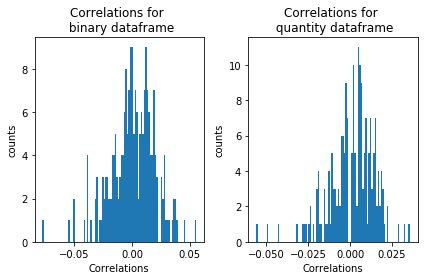

In [6]:
# illustration of the correlation between each variable and the ranking
variableToRankingCorr_quantity = corrMatrix_quantity.iloc[0].drop('Ranking')
variableToRankingCorr_binary = corrMatrix_binary.iloc[0].drop('Ranking')
fig, ax = plt.subplots(1, 2)

#fig.suptitle('Correlations of the ingredients and the ranking')
ax[0].hist(variableToRankingCorr_binary,bins = 100)
ax[0].set_title('Correlations for \n binary dataframe')
ax[0].set_xlabel('Correlations')
ax[0].set_ylabel('counts')
ax[1].hist(variableToRankingCorr_quantity,bins = 100)
ax[1].set_title('Correlations for \n quantity dataframe')
ax[1].set_xlabel('Correlations')
ax[1].set_ylabel('counts')
plt.tight_layout()
plt.show()

We can see on this histogram that most of the variables are not correlated with the ranking. Then, we can select our features by keeping only the variables which have a reasonnable correlation with the ranking. This method of selection gives representative results iff the variables are linear enough with the ranking. We will test more robust methods for feature selection later, as PCA, ICA, random forest, ...

In [7]:
# We will choose a threshold such as we keep only the correlations bigger than it.
threshold = 0.01
variableToKeep_binary = variableToRankingCorr_binary[np.abs(variableToRankingCorr_binary) > threshold]
variableToKeep_binary = variableToKeep_binary.index.values
features_binary = variableToKeep_binary
print('number of features for binary dataframe : {}'.format(len(features_binary)))
variableToKeep_quantity = variableToRankingCorr_quantity[np.abs(variableToRankingCorr_quantity) > threshold]
variableToKeep_quantity = variableToKeep_quantity.index.values
features_quantity = variableToKeep_quantity
print('number of features for quantity dataframe : {}'.format(len(features_quantity)))

number of features for binary dataframe : 125
number of features for quantity dataframe : 85


Here we have a very easy way to select our features. We can now select a training set and a testing test, after what we can implement and test a regression model of order 1.

### Drop every ingredient that don't have enough correlation with the final ranking

In [8]:
columns_to_keep_binary = features_binary.tolist()
columns_to_keep_binary.extend(['Ranking','Prepare time'])
drop_columns_binary = list(set(Ranking_ingredients_binary.columns) - set(columns_to_keep_binary))  #List of columns to drop
Ranking_ingredients_binary = Ranking_ingredients_binary.drop(drop_columns_binary, axis=1)

columns_to_keep_quantity = features_quantity.tolist()
columns_to_keep_quantity.extend(['Ranking','Prepare time'])
drop_columns_quantity = list(set(Ranking_ingredients_quantity.columns) - set(columns_to_keep_quantity))  #List of columns to drop
Ranking_ingredients_quantity = Ranking_ingredients_quantity.drop(drop_columns_quantity, axis=1)
#Ranking_ingredients_binary.head(10)
Ranking_ingredients_quantity.head(10)

,Ranking,salt,egg,sugar,flour,onion,black pepper,water,olive oil,milk,...,jalapeno,beer,spaghetti,onion soup,poultry,yellow bell pepper,pineapple juice,caper,cayenne,tofu
0,4.86,0.005272,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.022685,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.13,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.00,0.000869,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.67,0.028340,0.0,0.000000,0.900167,0.000000,0.0,0.000000,0.060976,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.972696,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.25,0.002857,0.0,0.000000,0.000000,0.000000,0.0,0.098126,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.91,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.652654,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5.00,0.000550,0.0,0.163354,0.000000,0.000000,0.0,0.000000,0.000000,0.527203,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.00,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4.75,0.001621,0.0,0.000000,0.000000,0.086128,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.094994,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save the result as pickle V2 of Ranking_ingredients_quantity

In [9]:
Ranking_ingredients_binary.to_pickle("data_pickles/Ranking_ingredients_binary_v2.pkl")
Ranking_ingredients_quantity.to_pickle("data_pickles/Ranking_ingredients_quantity_v2.pkl")

Read the result as pickle V2 of Ranking_ingredients_quantity

In [10]:
Ranking_ingredients_binary = pd.read_pickle("data_pickles/Ranking_ingredients_binary_v2.pkl")
Ranking_ingredients_quantity = pd.read_pickle("data_pickles/Ranking_ingredients_quantity_v2.pkl")

In [11]:
print('shape of binary dataframe : {}'.format(Ranking_ingredients_binary.shape))
print('shape of quantity dataframe : {}'.format(Ranking_ingredients_quantity.shape))

shape of binary dataframe : (24671, 126)
shape of quantity dataframe : (24831, 86)


### Now we go for the ML part, we try to predict the Ranking by looking at our ingredient, we first implementation  a linear regression using Rigide regression

First we split our dataset in train and test

In [12]:
#Split the dataset for quantity dataframe
train_x_q, test_x_q,train_y_q, test_y_q = train_test_split(Ranking_ingredients_quantity\
                        .drop(['Ranking'], axis = 1), Ranking_ingredients_quantity['Ranking'], test_size=0.30)
#Split the dataset for binary dataframe
train_x_b, test_x_b,train_y_b, test_y_b = train_test_split(Ranking_ingredients_binary\
                        .drop(['Ranking'], axis = 1), Ranking_ingredients_binary['Ranking'], test_size=0.30)

We try to determine the best alpha to fit in the best way our data.

In [13]:
alpha_range = np.linspace(0, 100, num=20)
error_train_q = np.zeros(len(alpha_range))
error_train_b = np.zeros(len(alpha_range))
for reg_param in range(len(alpha_range)):
    ridge = Ridge(alpha=alpha_range[reg_param])
    scores_q = cross_validate(ridge,  train_x_q, train_y_q, cv=5,scoring=("neg_mean_squared_error"))
    scores_b = cross_validate(ridge,  train_x_b, train_y_b, cv=5,scoring=("neg_mean_squared_error"))
    error_train_q[reg_param] = np.abs(np.mean(scores_q["test_score"]))
    error_train_b[reg_param] = np.abs(np.mean(scores_b["test_score"]))

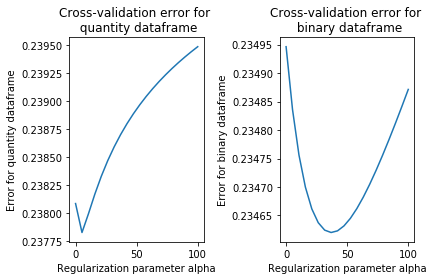

In [14]:
fig, ax = plt.subplots(1, 2)
#fig.suptitle('Cross-validation error as a function of alpha')
ax[0].plot(alpha_range, error_train_q)
ax[0].set_title('Cross-validation error for \n quantity dataframe')
ax[0].set_xlabel('Regularization parameter alpha')
ax[0].set_ylabel('Error for quantity dataframe')
ax[1].plot(alpha_range, error_train_b)
ax[1].set_title('Cross-validation error for \n binary dataframe')
ax[1].set_xlabel('Regularization parameter alpha')
ax[1].set_ylabel('Error for binary dataframe')
plt.tight_layout()
plt.show()

In [15]:
best_alpha_q = np.argmin(error_train_q)
best_alpha_b = np.argmin(error_train_b)

print('The alpha for quantity dataframe giving the lowest error is:', alpha_range[best_alpha_q])
print('The alpha for binary dataframe giving the lowest error is:', alpha_range[best_alpha_b])

The alpha for quantity dataframe giving the lowest error is: 5.2631578947368425
The alpha for binary dataframe giving the lowest error is: 36.8421052631579


We train the model with the best alpha we have obtain before obtained, and we test it over our test set to determine the error (with this step we can see if we are have overfitting):

In [16]:
#Test the model with quantity dataframe
ridge_opt_q = Ridge(alpha = alpha_range[best_alpha_q])
ridge_opt_q.fit(train_x_q, train_y_q)
print('Mean squared error for quantity dataframe :', mean_squared_error(test_y_q, ridge_opt_q.predict(test_x_q)))

ridge_opt_b = Ridge(alpha = alpha_range[best_alpha_b])
ridge_opt_b.fit(train_x_b, train_y_b)
print('Mean squared error for binary dataframe :', mean_squared_error(test_y_b, ridge_opt_b.predict(test_x_b)))

Mean squared error for quantity dataframe : 0.24108900378161033
Mean squared error for binary dataframe : 0.23668677685628062


We can see that the error obtain are similar, so there is no meaning in the quantity (no supplementary information). To understand in a better way the ouput error of our model we can plot the histogram of the ranking.

Histogram of the Ranking

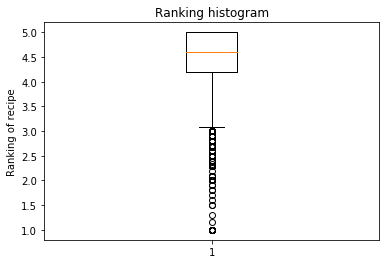

The median of Ranking is at: 4.6


In [17]:
#fig.suptitle('Cross-validation error as a function of alpha')
plt.boxplot(Ranking_ingredients_quantity['Ranking'])
plt.title('Ranking histogram')
plt.ylabel('Ranking of recipe')
#plt.ylabel('Counts')
plt.show()
print('The median of Ranking is at:',Ranking_ingredients_quantity['Ranking'].quantile(0.5))

So a error of around 0.24 for such a boxplot is not very good

### Discret Machine learning programming

We have not been able to determine with precision de ranking of a recipe. However, we can predict if a recipe is good or not.

Usefull fonction to reduce the time to run

In [18]:
def Ranking_function(bottom_value,top_value,Ranking_value):
    if Ranking_value > bottom_value:
        if Ranking_value > top_value:
            Ranking = 2.0
        else:
            Ranking = 1.0
    else:
        Ranking = 0.0
    return Ranking

def Ranking_function_unique(Ranking_threshold,Ranking_value):
    if Ranking_value > Ranking_threshold:
        Ranking = 1.0
    else:
        Ranking = 0.0
    return Ranking

def float2binary(value):
    if value>0.5:
        return 1.0
    else:
        return 0.0

#### Implement a Linear regression 'lbfgs'
Implement a Linear regression 'lbfgs' to determine an output of 0 and 1, 0 mean the recipe is not good and 1 means that the recipe is good,  first we try to determine the f1 score by changing the threshold value with which we determine if the recipe is good or not.

In [19]:
#To ignore our warnings
import warnings
warnings.filterwarnings('ignore')

In [32]:
Ranking_threshold_list = np.linspace(3, 4.9, num=20)
f1_score_list_q = np.zeros((len(Ranking_threshold_list),1))
f1_score_list_b = np.zeros((len(Ranking_threshold_list),1))
RI_Rating_threshold_q = Ranking_ingredients_quantity.copy()
RI_Rating_threshold_b = Ranking_ingredients_binary.copy()

for idx_Ranking in range(len(Ranking_threshold_list)):
    Ranking = Ranking_threshold_list[idx_Ranking]
    
    #Determine if the recipe is good or not by putting 0 or 1 in the Ranking column
    RI_Rating_threshold_q['Ranking'] = Ranking_ingredients_quantity['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
    RI_Rating_threshold_b['Ranking'] = Ranking_ingredients_binary['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
    
    #Split the dataset in train and test
    x_train_q, x_test_q,y_train_q, y_test_q = train_test_split(RI_Rating_threshold_q\
                    .drop(['Ranking'], axis = 1), RI_Rating_threshold_q['Ranking'], test_size=0.30)
    x_train_b, x_test_b,y_train_b, y_test_b = train_test_split(RI_Rating_threshold_b\
                    .drop(['Ranking'], axis = 1), RI_Rating_threshold_b['Ranking'], test_size=0.30)
    
    #create the model 
    logistic_q = LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=500)
    logistic_q.fit(x_train_q, y_train_q)
    logistic_b = LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=500)
    logistic_b.fit(x_train_b, y_train_b)

    #predict the output
    y_pred_q = logistic_q.predict(x_test_q)
    y_pred_b = logistic_b.predict(x_test_b)

    #test the model on the test set
    f1_score_list_q[idx_Ranking] = f1_score(y_test_q, y_pred_q, average='macro')
    f1_score_list_b[idx_Ranking] = f1_score(y_test_b, y_pred_b, average='macro')

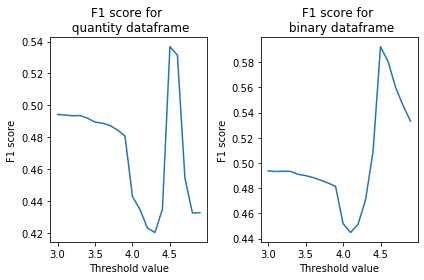

In [33]:
fig, ax = plt.subplots(1, 2)
#fig.suptitle('Cross-validation error as a function of alpha')
ax[0].plot( Ranking_threshold_list, f1_score_list_q)
ax[0].set_title('F1 score for \n quantity dataframe')
ax[0].set_xlabel('Threshold value')
ax[0].set_ylabel('F1 score')
ax[1].plot( Ranking_threshold_list, f1_score_list_b)
ax[1].set_title('F1 score for \n binary dataframe')
ax[1].set_xlabel('Threshold value')
ax[1].set_ylabel('F1 score')
plt.tight_layout()
plt.show()

Retrain the model with the best ranking value depending on the highest f1 score to plot the confusion matrix

For the quantity Dataframe the f1-score using logitic is: 0.5372190209328598 with a Ranking threshold: 4.5 and a confusion matrix (plot below):


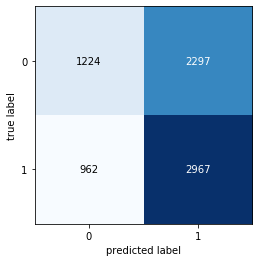

For the binary Dataframe the f1-score using logitic is: 0.5857408461022295 with a Ranking threshold: 4.5 and a confusion matrix (plot below):


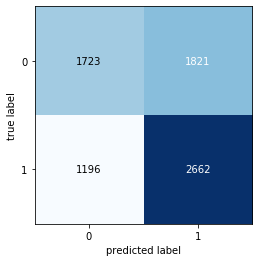

In [34]:
#Determine the index of the highest f1 measure
index_argmax_q=np.argmax(f1_score_list_q)
index_argmax_b=np.argmax(f1_score_list_b)

#Determine if the recipe is good or not by putting 0 or 1 in the Ranking column
RI_Rating_threshold_q['Ranking'] = Ranking_ingredients_quantity['Ranking'].apply(lambda x:Ranking_function_unique(Ranking_threshold_list[index_argmax_q],x))
RI_Rating_threshold_b['Ranking'] = Ranking_ingredients_binary['Ranking'].apply(lambda x:Ranking_function_unique(Ranking_threshold_list[index_argmax_b],x))

#Split the dataset in train and test
x_train_q, x_test_q,y_train_q, y_test_q = train_test_split(RI_Rating_threshold_q\
                .drop(['Ranking'], axis = 1), RI_Rating_threshold_q['Ranking'], test_size=0.30)
x_train_b, x_test_b,y_train_b, y_test_b = train_test_split(RI_Rating_threshold_b\
                .drop(['Ranking'], axis = 1), RI_Rating_threshold_b['Ranking'], test_size=0.30)

#create the model 
logistic_q = LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=500)
logistic_q.fit(x_train_q, y_train_q)
logistic_b = LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=500)
logistic_b.fit(x_train_b, y_train_b)

#predict the output
y_pred_q = logistic_q.predict(x_test_q)
y_pred_b = logistic_b.predict(x_test_b)

#test the model on the test set to determine f1
f1_score_list_optimized_q = f1_score(y_test_q, y_pred_q, average='macro')
f1_score_list_optimized_b = f1_score(y_test_b, y_pred_b, average='macro')

#Determine the confusion matrix
confusion_matrix_q = confusion_matrix(y_test_q, y_pred_q)
confusion_matrix_b = confusion_matrix(y_test_b, y_pred_b)


#Print our result

#For the quantity Dataframe
print('For the quantity Dataframe the f1-score using logitic is:',f1_score_list_optimized_q,'with a Ranking threshold:',Ranking_threshold_list[index_argmax_q],'and a confusion matrix (plot below):')
#To print in a nice way the confusion matrix 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_q)
plt.show()

#For the quantity Dataframe
print('For the binary Dataframe the f1-score using logitic is:',f1_score_list_optimized_b,'with a Ranking threshold:',Ranking_threshold_list[index_argmax_b],'and a confusion matrix (plot below):')
#To print in a nice way the confusion matrix 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_b)
plt.show()

#### If we have time try to implement with more than 2 outputs

### Try to implement Random forest

As we have seen with the previous ML, the best Ranking threshold is 4.5 and because we don't want to complexify the problem we will use a Ranking threshold of 4.5 for all our futurs models.
- In the Random forest model we will tune the max_depth paramter 

In [49]:
max_depth_list = np.linspace(1, 100, num=10)
f1_score_list_q = np.zeros((len(max_depth_list),1))
f1_score_list_b = np.zeros((len(max_depth_list),1))
RI_Rating_threshold_q = Ranking_ingredients_quantity.copy()
RI_Rating_threshold_b = Ranking_ingredients_binary.copy()
Ranking = 4.5


for idx_max_depth in range(len(max_depth_list)):
    max_depth_i = max_depth_list[idx_max_depth]
    
    #Determine if the recipe is good or not by putting 0 or 1 in the Ranking column
    RI_Rating_threshold_q['Ranking'] = Ranking_ingredients_quantity['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
    RI_Rating_threshold_b['Ranking'] = Ranking_ingredients_binary['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
    
    #Split the dataset in train and test
    x_train_q, x_test_q,y_train_q, y_test_q = train_test_split(RI_Rating_threshold_q\
                    .drop(['Ranking'], axis = 1), RI_Rating_threshold_q['Ranking'], test_size=0.30)
    x_train_b, x_test_b,y_train_b, y_test_b = train_test_split(RI_Rating_threshold_b\
                    .drop(['Ranking'], axis = 1), RI_Rating_threshold_b['Ranking'], test_size=0.30)
    
    #create the model 
    RF_q = RandomForestRegressor(max_depth=max_depth_i,random_state=0)
    RF_q.fit(x_train_q, y_train_q)
    RF_b = RandomForestRegressor(max_depth=max_depth_i,random_state=0)
    RF_b.fit(x_train_b, y_train_b)

    #predict the output
    y_pred_q = RF_q.predict(x_test_q)
    y_pred_b = RF_b.predict(x_test_b)
    
    #We have to create a bolean output, we don't want value between 0 and 1 but we want 0 or 1, this is done by using a threshold at 0.5
    y_pred_q = pd.Series(y_pred_q)
    y_pred_q = y_pred_q.apply(lambda x:float2binary(x))
    y_pred_b = pd.Series(y_pred_b)
    y_pred_b = y_pred_b.apply(lambda x:float2binary(x))

    #test the model on the test set
    f1_score_list_q[idx_max_depth] = f1_score(y_test_q, y_pred_q, average='macro')
    f1_score_list_b[idx_max_depth] = f1_score(y_test_b, y_pred_b, average='macro')

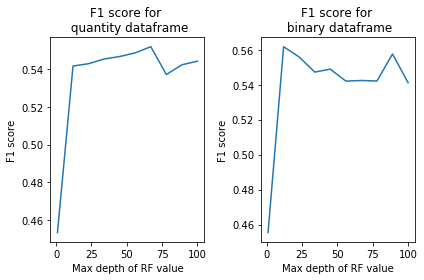

In [50]:
fig, ax = plt.subplots(1, 2)
#fig.suptitle('Cross-validation error as a function of alpha')
ax[0].plot(max_depth_list, f1_score_list_q)
ax[0].set_title('F1 score for \n quantity dataframe')
ax[0].set_xlabel('Max depth of RF value')
ax[0].set_ylabel('F1 score')
ax[1].plot(max_depth_list, f1_score_list_b)
ax[1].set_title('F1 score for \n binary dataframe')
ax[1].set_xlabel('Max depth of RF value')
ax[1].set_ylabel('F1 score')
plt.tight_layout()
plt.show()

Retrain the model with the best max depth value depending on the highest f1 score to plot the confusion matrix

For the quantity Dataframe the f1-score using logitic is: 0.5372190209328598 with a max depth value: 67.0 and a confusion matrix (plot below):


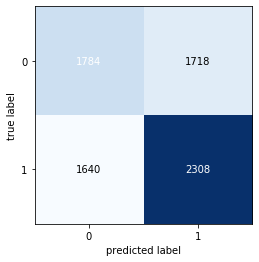

For the binary Dataframe the f1-score using logitic is: 0.5857408461022295 with a max depth value: 12.0 and a confusion matrix (plot below):


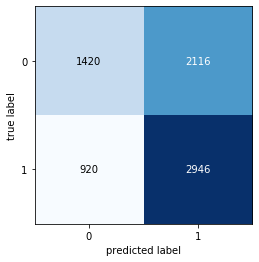

In [51]:
#Determine the index of the highest f1 measure
index_argmax_q = np.argmax(f1_score_list_q)
index_argmax_b = np.argmax(f1_score_list_b)

max_depth_q = max_depth_list[index_argmax_q]
max_depth_b = max_depth_list[index_argmax_b]

#Determine if the recipe is good or not by putting 0 or 1 in the Ranking column
RI_Rating_threshold_q['Ranking'] = Ranking_ingredients_quantity['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
RI_Rating_threshold_b['Ranking'] = Ranking_ingredients_binary['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))

#Split the dataset in train and test
x_train_q, x_test_q,y_train_q, y_test_q = train_test_split(RI_Rating_threshold_q\
                .drop(['Ranking'], axis = 1), RI_Rating_threshold_q['Ranking'], test_size=0.30)
x_train_b, x_test_b,y_train_b, y_test_b = train_test_split(RI_Rating_threshold_b\
                .drop(['Ranking'], axis = 1), RI_Rating_threshold_b['Ranking'], test_size=0.30)

#create the model 
RF_q = RandomForestRegressor(max_depth=max_depth_q,random_state=0)
RF_q.fit(x_train_q, y_train_q)
RF_b = RandomForestRegressor(max_depth=max_depth_b,random_state=0)
RF_b.fit(x_train_b, y_train_b)

#predict the output
y_pred_q = RF_q.predict(x_test_q)
y_pred_b = RF_b.predict(x_test_b)

#We have to create a bolean output, we don't want value between 0 and 1 but we want 0 or 1, this is done by using a threshold at 0.5
y_pred_q = pd.Series(y_pred_q)
y_pred_q = y_pred_q.apply(lambda x:float2binary(x))
y_pred_b = pd.Series(y_pred_b)
y_pred_b = y_pred_b.apply(lambda x:float2binary(x))

#test the model on the test set
f1_score_list_q[idx_max_depth] = f1_score(y_test_q, y_pred_q, average='macro')
f1_score_list_b[idx_max_depth] = f1_score(y_test_b, y_pred_b, average='macro')

#Determine the confusion matrix
confusion_matrix_q = confusion_matrix(y_test_q, y_pred_q)
confusion_matrix_b = confusion_matrix(y_test_b, y_pred_b)


#Print our result

#For the quantity Dataframe
print('For the quantity Dataframe the f1-score using logitic is:',f1_score_list_optimized_q,'with a max depth value:',max_depth_q,'and a confusion matrix (plot below):')
#To print in a nice way the confusion matrix 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_q)
plt.show()

#For the quantity Dataframe
print('For the binary Dataframe the f1-score using logitic is:',f1_score_list_optimized_b,'with a max depth value:',max_depth_b,'and a confusion matrix (plot below):')
#To print in a nice way the confusion matrix 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_b)
plt.show()

### Try to implement KNN

- In the KNN model we tune the nearest neighbors

In [61]:
n_neighbors_list = np.linspace(1, 100, num=10).astype(int)
f1_score_list_q = np.zeros((len(n_neighbors_list),1))
f1_score_list_b = np.zeros((len(n_neighbors_list),1))
RI_Rating_threshold_q = Ranking_ingredients_quantity.copy()
RI_Rating_threshold_b = Ranking_ingredients_binary.copy()
Ranking = 4.5
for idx_n_neighbors in range(len(n_neighbors_list)):
    n_neighbors_i = n_neighbors_list[idx_n_neighbors]
    
    #Determine if the recipe is good or not by putting 0 or 1 in the Ranking column
    RI_Rating_threshold_q['Ranking'] = Ranking_ingredients_quantity['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
    RI_Rating_threshold_b['Ranking'] = Ranking_ingredients_binary['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
    
    #Split the dataset in train and test
    x_train_q, x_test_q,y_train_q, y_test_q = train_test_split(RI_Rating_threshold_q\
                    .drop(['Ranking'], axis = 1), RI_Rating_threshold_q['Ranking'], test_size=0.30)
    x_train_b, x_test_b,y_train_b, y_test_b = train_test_split(RI_Rating_threshold_b\
                    .drop(['Ranking'], axis = 1), RI_Rating_threshold_b['Ranking'], test_size=0.30)
    
    #create the model 
    KNN_q = KNeighborsClassifier(n_neighbors=n_neighbors_i)
    KNN_q.fit(x_train_q, y_train_q)
    KNN_b = KNeighborsClassifier(n_neighbors=n_neighbors_i)
    KNN_b.fit(x_train_b, y_train_b)

    #predict the output
    y_pred_q = logistic_q.predict(x_test_q)
    y_pred_b = logistic_b.predict(x_test_b)

    #test the model on the test set
    f1_score_list_q[idx_n_neighbors] = f1_score(y_test_q, y_pred_q, average='macro')
    f1_score_list_b[idx_n_neighbors] = f1_score(y_test_b, y_pred_b, average='macro')

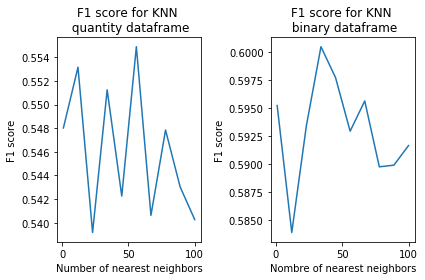

In [62]:
fig, ax = plt.subplots(1, 2)
#fig.suptitle('Cross-validation error as a function of alpha')
ax[0].plot(n_neighbors_list, f1_score_list_q)
ax[0].set_title('F1 score for KNN \n quantity dataframe')
ax[0].set_xlabel('Number of nearest neighbors')
ax[0].set_ylabel('F1 score')
ax[1].plot(n_neighbors_list, f1_score_list_b)
ax[1].set_title('F1 score for KNN \n binary dataframe')
ax[1].set_xlabel('Nombre of nearest neighbors')
ax[1].set_ylabel('F1 score')
plt.tight_layout()
plt.show()

For the quantity Dataframe the f1-score using KNN is: 0.5496938448243909 with a nearest neighbor: 56 and a confusion matrix (plot below):


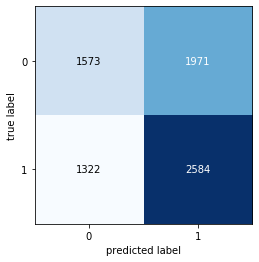

For the binary Dataframe the f1-score using KNN is: 0.5521557927739623 with a nearest neighbor: 34 and a confusion matrix (plot below):


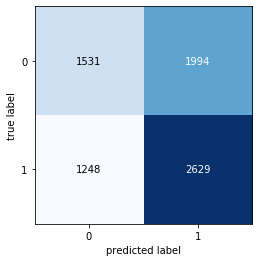

In [69]:
#Determine the index of the highest f1 measure
index_argmax_q=np.argmax(f1_score_list_q)
index_argmax_b=np.argmax(f1_score_list_b)

n_neighbors_q = n_neighbors_list[index_argmax_q]
n_neighbors_b = n_neighbors_list[index_argmax_b]
#Determine if the recipe is good or not by putting 0 or 1 in the Ranking column
RI_Rating_threshold_q['Ranking'] = Ranking_ingredients_quantity['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
RI_Rating_threshold_b['Ranking'] = Ranking_ingredients_binary['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))

#Split the dataset in train and test
x_train_q, x_test_q,y_train_q, y_test_q = train_test_split(RI_Rating_threshold_q\
                .drop(['Ranking'], axis = 1), RI_Rating_threshold_q['Ranking'], test_size=0.30)
x_train_b, x_test_b,y_train_b, y_test_b = train_test_split(RI_Rating_threshold_b\
                .drop(['Ranking'], axis = 1), RI_Rating_threshold_b['Ranking'], test_size=0.30)

#create the model 
KNN_q = KNeighborsClassifier(n_neighbors = n_neighbors_q)
KNN_q.fit(x_train_q, y_train_q)
KNN_b = KNeighborsClassifier(n_neighbors = n_neighbors_b)
KNN_b.fit(x_train_b, y_train_b)

#predict the output
y_pred_q = KNN_q.predict(x_test_q)
y_pred_b = KNN_b.predict(x_test_b)

#test the model on the test set to determine f1
f1_score_list_optimized_q = f1_score(y_test_q, y_pred_q, average='macro')
f1_score_list_optimized_b = f1_score(y_test_b, y_pred_b, average='macro')

#Determine the confusion matrix
confusion_matrix_q = confusion_matrix(y_test_q, y_pred_q)
confusion_matrix_b = confusion_matrix(y_test_b, y_pred_b)


#Print our result

#For the quantity Dataframe
print('For the quantity Dataframe the f1-score using KNN is:',f1_score_list_optimized_q,'with a nearest neighbor:',n_neighbors_q,'and a confusion matrix (plot below):')
#To print in a nice way the confusion matrix 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_q)
plt.show()

#For the quantity Dataframe
print('For the binary Dataframe the f1-score using KNN is:',f1_score_list_optimized_b,'with a nearest neighbor:',n_neighbors_b,'and a confusion matrix (plot below):')
#To print in a nice way the confusion matrix 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_b)
plt.show()

### Try to implement for neural network

In [70]:
hidden_layer_sizes_list = np.linspace(10, 20, num=2).astype(int)
f1_score_list_q = np.zeros((len(hidden_layer_sizes_list),1))
f1_score_list_b = np.zeros((len(hidden_layer_sizes_list),1))
RI_Rating_threshold_q = Ranking_ingredients_quantity.copy()
RI_Rating_threshold_b = Ranking_ingredients_binary.copy()
Ranking = 4.5

for idx_hidden_layer in range(len(hidden_layer_sizes_list)):
    hls_i = hidden_layer_sizes_list[idx_hidden_layer]
    
    #Determine if the recipe is good or not by putting 0 or 1 in the Ranking column
    RI_Rating_threshold_q['Ranking'] = Ranking_ingredients_quantity['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
    RI_Rating_threshold_b['Ranking'] = Ranking_ingredients_binary['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
    
    #Split the dataset in train and test
    x_train_q, x_test_q,y_train_q, y_test_q = train_test_split(RI_Rating_threshold_q\
                    .drop(['Ranking'], axis = 1), RI_Rating_threshold_q['Ranking'], test_size=0.30)
    x_train_b, x_test_b,y_train_b, y_test_b = train_test_split(RI_Rating_threshold_b\
                    .drop(['Ranking'], axis = 1), RI_Rating_threshold_b['Ranking'], test_size=0.30)
    
    #create the model 
    mlp_q = MLPClassifier(hidden_layer_sizes=(hls_i,hls_i,hls_i), max_iter=1000)
    mlp_q.fit(x_train_q, y_train_q)
    mlp_b = MLPClassifier(hidden_layer_sizes=(hls_i,hls_i,hls_i), max_iter=1000)
    mlp_b.fit(x_train_b, y_train_b)

    #predict the output
    y_pred_q = mlp_q.predict(x_test_q)
    y_pred_b = mlp_b.predict(x_test_b)

    #test the model on the test set
    f1_score_list_q[idx_hidden_layer] = f1_score(y_test_q, y_pred_q, average='macro')
    f1_score_list_b[idx_hidden_layer] = f1_score(y_test_b, y_pred_b, average='macro')

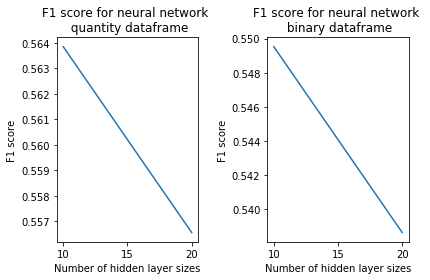

In [72]:
fig, ax = plt.subplots(1, 2)
#fig.suptitle('Cross-validation error as a function of alpha')
ax[0].plot(hidden_layer_sizes_list, f1_score_list_q)
ax[0].set_title('F1 score for neural network \n quantity dataframe')
ax[0].set_xlabel('Number of hidden layer sizes')
ax[0].set_ylabel('F1 score')
ax[1].plot(hidden_layer_sizes_list, f1_score_list_b)
ax[1].set_title('F1 score for neural network \n binary dataframe')
ax[1].set_xlabel('Number of hidden layer sizes')
ax[1].set_ylabel('F1 score')
plt.tight_layout()
plt.show()

For the quantity Dataframe the f1-score using neural network is: 0.5678004758777511 with a hidden layer sizes: 10 and a confusion matrix (plot below):


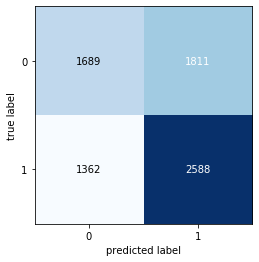

For the binary Dataframe the f1-score using neural network is: 0.5586435444668125 with a hidden layer sizes: 10 and a confusion matrix (plot below):


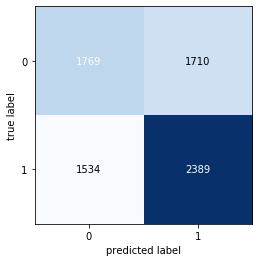

In [73]:
#Determine the index of the highest f1 measure
index_argmax_q = np.argmax(f1_score_list_q)
index_argmax_b = np.argmax(f1_score_list_b)

hls_q = hidden_layer_sizes_list[index_argmax_q]
hls_b = hidden_layer_sizes_list[index_argmax_b]

#Determine if the recipe is good or not by putting 0 or 1 in the Ranking column
RI_Rating_threshold_q['Ranking'] = Ranking_ingredients_quantity['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
RI_Rating_threshold_b['Ranking'] = Ranking_ingredients_binary['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))

#Split the dataset in train and test
x_train_q, x_test_q,y_train_q, y_test_q = train_test_split(RI_Rating_threshold_q\
                .drop(['Ranking'], axis = 1), RI_Rating_threshold_q['Ranking'], test_size=0.30)
x_train_b, x_test_b,y_train_b, y_test_b = train_test_split(RI_Rating_threshold_b\
                .drop(['Ranking'], axis = 1), RI_Rating_threshold_b['Ranking'], test_size=0.30)

#create the model 
mlp_q = MLPClassifier(hidden_layer_sizes=(hls_q,hls_q,hls_q), max_iter=1000)
mlp_q.fit(x_train_q, y_train_q)
mlp_b = MLPClassifier(hidden_layer_sizes=(hls_q,hls_q,hls_q), max_iter=1000)
mlp_b.fit(x_train_b, y_train_b)

#predict the output
y_pred_q = mlp_q.predict(x_test_q)
y_pred_b = mlp_b.predict(x_test_b)

#test the model on the test set to determine f1
f1_score_list_optimized_q = f1_score(y_test_q, y_pred_q, average='macro')
f1_score_list_optimized_b = f1_score(y_test_b, y_pred_b, average='macro')

#Determine the confusion matrix
confusion_matrix_q = confusion_matrix(y_test_q, y_pred_q)
confusion_matrix_b = confusion_matrix(y_test_b, y_pred_b)


#Print our result

#For the quantity Dataframe
print('For the quantity Dataframe the f1-score using neural network is:',f1_score_list_optimized_q,'with a hidden layer sizes:',hls_q,'and a confusion matrix (plot below):')
#To print in a nice way the confusion matrix 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_q)
plt.show()

#For the quantity Dataframe
print('For the binary Dataframe the f1-score using neural network is:',f1_score_list_optimized_b,'with a hidden layer sizes:',hls_b,'and a confusion matrix (plot below):')
#To print in a nice way the confusion matrix 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_b)
plt.show()

#### Try to implement 3 machine learning models to determine the output
- try to implement the 3 model together to get the hishest f1 value

In [ ]:
#Determine if the recipe is good or not by putting 0 or 1 in the Ranking column
RI_Rating_threshold_q['Ranking'] = Ranking_ingredients_quantity['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))
RI_Rating_threshold_b['Ranking'] = Ranking_ingredients_binary['Ranking'].apply(lambda x:Ranking_function_unique(Ranking,x))

#Split the dataset in train and test
x_train_q, x_test_q,y_train_q, y_test_q = train_test_split(RI_Rating_threshold_q\
                .drop(['Ranking'], axis = 1), RI_Rating_threshold_q['Ranking'], test_size=0.30)
x_train_b, x_test_b,y_train_b, y_test_b = train_test_split(RI_Rating_threshold_b\
                .drop(['Ranking'], axis = 1), RI_Rating_threshold_b['Ranking'], test_size=0.30)



#create the model using KNN
KNN_q = KNeighborsClassifier(n_neighbors = n_neighbors_q)
KNN_q.fit(x_train_q, y_train_q)
KNN_b = KNeighborsClassifier(n_neighbors = n_neighbors_b)
KNN_b.fit(x_train_b, y_train_b)

#predict the output
y_pred_KNN_q = KNN_q.predict(x_test_q)
y_pred_KNN_b = KNN_b.predict(x_test_b)



#create the model using neural networ
mlp_q = MLPClassifier(hidden_layer_sizes=(hls_q,hls_q,hls_q), max_iter=1000)
mlp_q.fit(x_train_q, y_train_q)
mlp_b = MLPClassifier(hidden_layer_sizes=(hls_q,hls_q,hls_q), max_iter=1000)
mlp_b.fit(x_train_b, y_train_b)

#predict the output
y_pred_mlp_q = mlp_q.predict(x_test_q)
y_pred_mlp_b = mlp_b.predict(x_test_b)


#create the model using Random forest
RF_q = RandomForestRegressor(max_depth=max_depth_q,random_state=0)
RF_q.fit(x_train_q, y_train_q)
RF_b = RandomForestRegressor(max_depth=max_depth_b,random_state=0)
RF_b.fit(x_train_b, y_train_b)

#predict the output
y_pred_RF_q = RF_q.predict(x_test_q)
y_pred_RF_b = RF_b.predict(x_test_b)


#We take the mean of our output to determine if it is 1 or 0
y_pred_q = y_pred_RF_q + y_pred_mlp_q + y_pred_KNN_q
y_pred_b = y_pred_RF_b + y_pred_mlp_b + y_pred_KNN_b
    
y_pred_q = pd.Series(y_pred_q) 
y_pred_b = pd.Series(y_pred_b) 

y_pred_q = y_pred_q.apply(lambda x:1 if x>1.5 else 0)
y_pred_b = y_pred_b.apply(lambda x:1 if x>1.5 else 0)



#test the model on the test set to determine f1
f1_score_list_optimized_q = f1_score(y_test_q, y_pred_q, average='macro')
f1_score_list_optimized_b = f1_score(y_test_b, y_pred_b, average='macro')

#Determine the confusion matrix
confusion_matrix_q = confusion_matrix(y_test_q, y_pred_q)
confusion_matrix_b = confusion_matrix(y_test_b, y_pred_b)


#Print our result

#For the quantity Dataframe
print('For the quantity Dataframe the f1-score using 3 methods is:',f1_score_list_optimized_q,'with optimized parameters of all models and a confusion matrix (plot below):')
#To print in a nice way the confusion matrix 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_q)
plt.show()

#For the quantity Dataframe
print('For the binary Dataframe the f1-score using neural network is:',f1_score_list_optimized_b,'with optimized parameters of all models and a confusion matrix (plot below):')
#To print in a nice way the confusion matrix 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_b)
plt.show()